<a href="https://colab.research.google.com/github/verma-saloni/Thesis-Work/blob/main/Fasttext_Embeddings_XGboost_Politifact.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install unidecode
!pip install word2number
!pip install contractions

  Using cached Unidecode-1.3.3-py3-none-any.whl (235 kB)
  Created wheel for word2number: filename=word2number-1.1-py3-none-any.whl size=5582 sha256=81007015a0e36df60c913806a6019ced3388b929e905e3fe2f71bd3a91ff0058
  Stored in directory: /root/.cache/pip/wheels/4b/c3/77/a5f48aeb0d3efb7cd5ad61cbd3da30bbf9ffc9662b07c9f879
Successfully built word2number
  Using cached contractions-0.1.66-py2.py3-none-any.whl (8.0 kB)
  Using cached textsearch-0.0.21-py2.py3-none-any.whl (7.5 kB)
  Using cached anyascii-0.3.0-py3-none-any.whl (284 kB)
  Using cached pyahocorasick-1.4.4-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (106 kB)


In [2]:
import pandas as pd
import numpy as np
import nltk
import gensim
from gensim.models import Word2Vec
import string
string.punctuation
nltk.download('stopwords')
import re
from bs4 import BeautifulSoup
import spacy
import unidecode
from word2number import w2n
import contractions
from nltk.tokenize.treebank import TreebankWordDetokenizer
# load spacy model, can be "en_core_web_sm" as well
from sklearn.model_selection import train_test_split
import xgboost as xgb



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
df_fake = pd.read_csv('/content/drive/MyDrive/politifact_fake.csv')
df_real = pd.read_csv('/content/drive/MyDrive/politifact_real.csv')
df_fake['labelML']=0
df_real['labelML']=1

df_fake.count()


id           432
news_url     428
title        432
tweet_ids    392
labelML      432
dtype: int64

In [ ]:
#dforiginal = df_fake.head(5).append(df_real.head(5))

In [15]:
#df= df_fake.head(10).append(df_real.head(10))
df= df_fake.append(df_real)
df.reset_index(drop=True, inplace=True)

In [25]:
#print(df.columns)
df.count()
df

,id,news_url,title,tweet_ids,labelML
0,politifact15014,speedtalk.com/forum/viewtopic.php?t=51650,BREAKING: First NFL Team Declares Bankruptcy O...,937349434668498944\t937379378006282240\t937380...,0
1,politifact15156,politics2020.info/index.php/2018/03/13/court-o...,Court Orders Obama To Pay $400 Million In Rest...,972666281441878016\t972678396575559680\t972827...,0
2,politifact14745,www.nscdscamps.org/blog/category/parenting/467...,UPDATE: Second Roy Moore Accuser Works For Mic...,929405740732870656\t929439450400264192\t929439...,0
3,politifact14355,https://howafrica.com/oscar-pistorius-attempts...,Oscar Pistorius Attempts To Commit Suicide,886941526458347521\t887011300278194176\t887023...,0
4,politifact15371,http://washingtonsources.org/trump-votes-for-d...,Trump Votes For Death Penalty For Being Gay,915205698212040704\t915242076681506816\t915249...,0
...,...,...,...,...,...
1051,politifact14731,https://www.flake.senate.gov/public/index.cfm/...,Flake: “Religious tests should have no place i...,NaN,1
1052,politifact329,https://web.archive.org/web/20080131000131/htt...,Change We Can Believe In,634287923135909888\t946743411100536832\t946816...,1
1053,politifact1576,http://www.youtube.com/watch?v=4O8CxZ1OD58,deputy director of national health statistics ...,NaN,1
1054,politifact4720,http://www.youtube.com/watch?v=EhyMplwY6HY,Romneys ProLife Conversion Myth or Reality Jun...,188871706637647874,1


In [17]:
print(df)

                   id                                           news_url  \
0     politifact15014          speedtalk.com/forum/viewtopic.php?t=51650   
1     politifact15156  politics2020.info/index.php/2018/03/13/court-o...   
2     politifact14745  www.nscdscamps.org/blog/category/parenting/467...   
3     politifact14355  https://howafrica.com/oscar-pistorius-attempts...   
4     politifact15371  http://washingtonsources.org/trump-votes-for-d...   
...               ...                                                ...   
1051  politifact14731  https://www.flake.senate.gov/public/index.cfm/...   
1052    politifact329  https://web.archive.org/web/20080131000131/htt...   
1053   politifact1576         http://www.youtube.com/watch?v=4O8CxZ1OD58   
1054   politifact4720         http://www.youtube.com/watch?v=EhyMplwY6HY   
1055     politifact52  https://web.archive.org/web/20071102131244/htt...   

                                                  title  \
0     BREAKING: First NFL Te

In [18]:
df1= df.drop(['tweet_ids', 'news_url','id'], axis=1)
df1.count()

title      1056
labelML    1056
dtype: int64

In [19]:
# FOR URL Preprocessing now. 
dfurl = df.drop(['tweet_ids','id'], axis=1)
dfurl.head()

,news_url,title,labelML
0,speedtalk.com/forum/viewtopic.php?t=51650,BREAKING: First NFL Team Declares Bankruptcy O...,0
1,politics2020.info/index.php/2018/03/13/court-o...,Court Orders Obama To Pay $400 Million In Rest...,0
2,www.nscdscamps.org/blog/category/parenting/467...,UPDATE: Second Roy Moore Accuser Works For Mic...,0
3,https://howafrica.com/oscar-pistorius-attempts...,Oscar Pistorius Attempts To Commit Suicide,0
4,http://washingtonsources.org/trump-votes-for-d...,Trump Votes For Death Penalty For Being Gay,0


In [26]:
def remove_URL(sample):
    print(type(sample))
    if type(sample) == "str":
      return re.sub(r"http\S+", "", sample)

In [ ]:
#dfurl['news_url'] = dfurl['news_url'].apply(lambda x: ' '.join(remove_URL(x)))

In [27]:
# NLP Preprocessing
from gensim.utils import simple_preprocess

# NLP Preprocess - gensim.utils.simple_preprocess(doc, deacc=False, min_len=2, max_len=15)[source]
# Convert a document into a list of tokens.
# This lowercases, tokenizes, de-accents (optional). – the output are final tokens = unicode strings, that won’t be processed any further.

df1.iloc[:, 0] = df1.iloc[:, 0].apply(lambda x: ' '.join(simple_preprocess(x)))

In [28]:
print(df1)
df1.count()

                                                  title  labelML
0     breaking first nfl team declares bankruptcy ov...        0
1      court orders obama to pay million in restitution        0
2     update second roy moore accuser works for mich...        0
3            oscar pistorius attempts to commit suicide        0
4           trump votes for death penalty for being gay        0
...                                                 ...      ...
1051  flake religious tests should have no place in ...        1
1052                           change we can believe in        1
1053  deputy director of national health statistics ...        1
1054    romneys prolife conversion myth or reality june        1
1055                             interest group ratings        1

[1056 rows x 2 columns]


title      1056
labelML    1056
dtype: int64

In [29]:
print(df1)

                                                  title  labelML
0     breaking first nfl team declares bankruptcy ov...        0
1      court orders obama to pay million in restitution        0
2     update second roy moore accuser works for mich...        0
3            oscar pistorius attempts to commit suicide        0
4           trump votes for death penalty for being gay        0
...                                                 ...      ...
1051  flake religious tests should have no place in ...        1
1052                           change we can believe in        1
1053  deputy director of national health statistics ...        1
1054    romneys prolife conversion myth or reality june        1
1055                             interest group ratings        1

[1056 rows x 2 columns]


In [30]:
df1.count()

title      1056
labelML    1056
dtype: int64

In [31]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
!gunzip cc.en.300.bin.gz

--2022-03-05 10:14:29--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.74.142, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4503593528 (4.2G) [application/octet-stream]
Saving to: ‘cc.en.300.bin.gz’

cc.en.300.bin.gz    100%[===================>]   4.19G  39.5MB/s    in 1m 46s  

2022-03-05 10:16:15 (40.6 MB/s) - ‘cc.en.300.bin.gz’ saved [4503593528/4503593528]



trying to see similarity of vectors created.

In [32]:
!pip install fasttext
!pip install pyfasttext 

     |████████████████████████████████| 68 kB 3.4 MB/s 
  Using cached pybind11-2.9.1-py2.py3-none-any.whl (211 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3129232 sha256=d1ee584308cccc3591fc932138f2d2c305b0a42237f675aa46ec351f9925912d
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext
     |████████████████████████████████| 244 kB 5.2 MB/s 
  Using cached cysignals-1.11.2-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (871 kB)
  Created wheel for pyfasttext: filename=pyfasttext-0.4.6-cp37-cp37m-linux_x86_64.whl size=1460471 sha256=18a7217538d269ee24b26bf427b6ab4345f56973969470b668d58a0270afbb1f
  Stored in directory: /root/.cache/pip/wheels/e6/e7/60/c4506ea3173416f3774e221bd741d06bfc2127ec23ceff6619
Successfully built pyfasttext


In [33]:
!pip install fasttext
import fasttext as ft

!pip3 install pyfasttext
from pyfasttext import FastText

# Loading model for English
modelog = ft.load_model('cc.en.300.bin') 

In [36]:
c = modelog.get_sentence_vector('court orders obama to pay million in restitution')
d = modelog.get_sentence_vector('romneys prolife conversion myth or reality july')

In [37]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy import spatial
cosine_similarity = 1 - spatial.distance.cosine(c, d)
cosine_similarity

0.4243735373020172

In [38]:
modelog.get_nearest_neighbors('hello')

[(0.7143728733062744, 'hellow'),
 (0.7095366716384888, 'hello.'),
 (0.703833818435669, 'hi'),
 (0.6944323182106018, 'hullo'),
 (0.6912142038345337, 'hello-'),
 (0.663975715637207, 'Hello'),
 (0.6563249230384827, 'hello.I'),
 (0.6529381275177002, 'howdy'),
 (0.6283847689628601, 'hellooo'),
 (0.6235803365707397, 'hellooooo')]

In [39]:
embedding=[]
for line in df1['title']:
    pred_label=modelog.get_sentence_vector(line)
    embedding.append(pred_label)

# you add the list to the dataframe, then save the datframe to new csv
df1['prediction']=embedding
df1.to_csv('csv_word_embed_gossipcop.csv',index=False)

In [40]:
df1

,title,labelML,prediction
0,breaking first nfl team declares bankruptcy ov...,0,"[0.0069501833, 0.012378238, 0.006992966, 0.079..."
1,court orders obama to pay million in restitution,0,"[-0.043015987, 0.001276843, 0.04020724, 0.0318..."
2,update second roy moore accuser works for mich...,0,"[-0.033957314, 0.014177965, 0.0071734735, 0.06..."
3,oscar pistorius attempts to commit suicide,0,"[-0.048852272, -0.013508869, 0.029568031, 0.04..."
4,trump votes for death penalty for being gay,0,"[-0.00546249, 0.0050944164, -0.010664497, 0.07..."
...,...,...,...
1051,flake religious tests should have no place in ...,1,"[-0.026969075, 0.009240309, 0.01840479, 0.0655..."
1052,change we can believe in,1,"[-0.0300128, -0.002050096, 0.04633387, 0.05090..."
1053,deputy director of national health statistics ...,1,"[-0.0047038035, 0.0029697777, 0.008903842, 0.0..."
1054,romneys prolife conversion myth or reality june,1,"[-0.044189956, 0.004192572, -0.041098025, 0.00..."


In [41]:
type(df1)

pandas.core.frame.DataFrame

In [42]:
df3 = df1.drop(['title'], axis=1)
df3

,labelML,prediction
0,0,"[0.0069501833, 0.012378238, 0.006992966, 0.079..."
1,0,"[-0.043015987, 0.001276843, 0.04020724, 0.0318..."
2,0,"[-0.033957314, 0.014177965, 0.0071734735, 0.06..."
3,0,"[-0.048852272, -0.013508869, 0.029568031, 0.04..."
4,0,"[-0.00546249, 0.0050944164, -0.010664497, 0.07..."
...,...,...
1051,1,"[-0.026969075, 0.009240309, 0.01840479, 0.0655..."
1052,1,"[-0.0300128, -0.002050096, 0.04633387, 0.05090..."
1053,1,"[-0.0047038035, 0.0029697777, 0.008903842, 0.0..."
1054,1,"[-0.044189956, 0.004192572, -0.041098025, 0.00..."


In [43]:
#to split the embedding 
for index, arr in df3['prediction'].iteritems():
  for i in range(len(arr)):
    df3.loc[index, str(i)] = arr[i]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1684: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = infer_fill_value(value)


In [84]:
df3.to_pickle('ourpickle_politifact.pkl', compression=None)
df3.to_csv('title_embed_politifact.csv', index=False)
#to keep the files for reuse later. although xgboost gives error with just the pkl file, 0 features given error, can be checked later. 

In [85]:
df3

,labelML,prediction,0,1,2,3,4,5,6,7,...,290,291,292,293,294,295,296,297,298,299
0,0,"[0.0069501833, 0.012378238, 0.006992966, 0.079...",0.006950,0.012378,0.006993,0.079798,-0.076734,0.016184,0.023233,-0.027754,...,-0.002141,0.001098,-0.065715,0.016447,-0.012058,-0.006030,0.003967,0.060633,-0.001201,0.015366
1,0,"[-0.043015987, 0.001276843, 0.04020724, 0.0318...",-0.043016,0.001277,0.040207,0.031881,-0.071609,0.016816,0.021525,-0.028840,...,0.024870,-0.005575,-0.032846,0.005065,0.031414,0.009491,-0.020626,0.052110,0.016882,0.012650
2,0,"[-0.033957314, 0.014177965, 0.0071734735, 0.06...",-0.033957,0.014178,0.007173,0.068037,-0.052269,-0.003744,0.020675,0.002652,...,0.034091,-0.002843,-0.148873,0.025825,-0.007882,-0.000168,-0.001640,0.072320,-0.009994,-0.012056
3,0,"[-0.048852272, -0.013508869, 0.029568031, 0.04...",-0.048852,-0.013509,0.029568,0.047458,-0.018791,-0.032403,-0.032814,0.034912,...,0.024242,0.007002,-0.127479,0.019416,0.060609,0.009883,0.003603,0.055205,-0.016031,0.010726
4,0,"[-0.00546249, 0.0050944164, -0.010664497, 0.07...",-0.005462,0.005094,-0.010664,0.070058,-0.062735,-0.019179,0.031027,-0.003604,...,-0.005758,0.016082,-0.022874,0.028298,0.022922,0.017507,0.009065,0.031150,0.030781,0.034070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1051,1,"[-0.026969075, 0.009240309, 0.01840479, 0.0655...",-0.026969,0.009240,0.018405,0.065564,-0.069260,-0.020922,0.059876,-0.003409,...,0.034735,-0.049131,-0.056735,-0.002440,-0.012588,0.013866,0.034057,0.087729,0.014852,0.017551
1052,1,"[-0.0300128, -0.002050096, 0.04633387, 0.05090...",-0.030013,-0.002050,0.046334,0.050906,-0.092111,-0.032680,0.000134,-0.011542,...,0.085058,0.014162,-0.068230,0.021052,-0.002458,0.012554,0.032322,0.054333,-0.024740,0.047798
1053,1,"[-0.0047038035, 0.0029697777, 0.008903842, 0.0...",-0.004704,0.002970,0.008904,0.006196,-0.042154,0.020076,0.043571,0.003330,...,0.010371,0.009233,-0.042913,0.040871,-0.013417,0.007694,0.013532,0.075981,0.026263,0.008664
1054,1,"[-0.044189956, 0.004192572, -0.041098025, 0.00...",-0.044190,0.004193,-0.041098,0.006770,-0.064896,-0.030824,0.033080,-0.018795,...,-0.011757,0.011331,-0.086264,0.052676,0.015928,0.025641,0.022189,0.065121,-0.008549,0.063377


Will be attempting xgboost here.

In [86]:
#use when RUNTIME DISCONNECTED AND ONLY NEEDED FOR XGBOOST IMPLEMENTATION
df3 = pd.read_pickle('/content/ourpickle.pkl')

In [87]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [88]:
# split data into X and y
X = df3.iloc[:, 2:]
Y = df3['labelML']

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20,random_state=1,stratify=Y)

In [90]:
X_train.shape

(844, 300)

In [91]:
X_test.shape

(212, 300)

In [92]:
y_train

868    1
729    1
542    1
92     0
537    1
      ..
930    1
212    0
928    1
713    1
341    0
Name: labelML, Length: 844, dtype: int64

In [93]:
from collections import Counter
Counter(y_test).values()

dict_values([125, 87])

In [94]:
# Instantiate the XGBClassifier: xg_cl
xg_cl = xgb.XGBClassifier(objective='binary:logistic', n_estimators=10, seed=123)

# Fit the classifier to the training set
xg_cl.fit(X_train, y_train)

# Predict the labels of the test set: preds
y_pred = xg_cl.predict(X_test)

# Compute the accuracy: accuracy
accuracy = float(np.sum(y_pred == y_test)) / y_test.shape[0]
print("accuracy: %f" % (accuracy))

accuracy: 0.768868


In [95]:
from sklearn.neighbors import KNeighborsClassifier as KNN


In [96]:
from sklearn.metrics import confusion_matrix
#Source: https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/ 
#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

print(cf_matrix)

[[ 62  25]
 [ 24 101]]


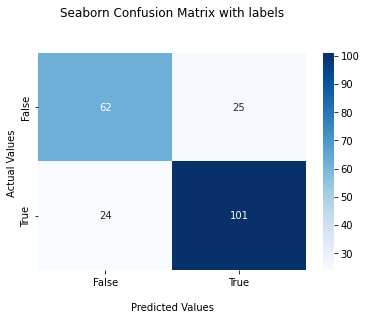

In [97]:
import seaborn as sns
from matplotlib import pyplot as plt

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt= '.3g')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

Next step, keras NN model.